# Preprocessing of Mutation Frequencies
This notebook is devoted to the preprocessing of TCGA mutation frequencies. I will derive a matrix, containing the mutation frequencies per samples (columns) and genes (rows).
This matrix will later be the feature matrix used by another notebook to form a hdf5 container.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import mygene
import h5py
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Parameters
* `USE_PRECOMPILED_MAF`: The flag indicates if the mutations to be used here should be the ones downloaded from synapse (https://www.synapse.org/#!Synapse:syn1729383) or own downloaded mafs across all cancers. The synapse data was also used by Hotnet2 while the other data is more recent but also maybe more error prone.

In [3]:
USE_PRECOMPILED_MAF = True

## Loading high confidence MAF file & CNAs

In [4]:
trim_fun = lambda x: '-'.join(str(x).split('-')[:4]) # TCGA barcode including sample

# load MAF
if USE_PRECOMPILED_MAF:
    sn_mutations = pd.read_csv('../data/pancancer/TCGA/pancan12_cleaned.maf', sep='\t')
else:
    sn_mutations = pd.read_csv('../data/pancancer/TCGA/all_mutations.maf')
sn_mutations.Tumor_Sample_Barcode = sn_mutations.Tumor_Sample_Barcode.map(trim_fun)

# load CNAs
cna_sample_matrix = pd.read_csv('../data/pancancer/TCGA/firehose_cnas_sample_20160128.tsv', sep='\t')
cna_sample_matrix.rename(columns={'Unnamed: 0':'Name'}, inplace=True)
cna_sample_matrix.set_index('Name', inplace=True)
cna_sample_matrix.rename(columns=trim_fun, inplace=True)

cna_mean_matrix = pd.read_csv('../data/pancancer/TCGA/firehose_cnas_meancancertypes_20160128.tsv', sep='\t')

In [5]:
print ("Found {} samples in MAF file".format(sn_mutations.Tumor_Sample_Barcode.nunique()))
print ("Found {} samples in CNA file".format(cna_sample_matrix.shape[1]))
samples_in_both = sn_mutations[sn_mutations.Tumor_Sample_Barcode.isin(cna_sample_matrix.columns)].Tumor_Sample_Barcode.nunique()
print ("Found {} samples in both, CNA and MAF".format(samples_in_both))

Found 3277 samples in MAF file
Found 6057 samples in CNA file
Found 2999 samples in both, CNA and MAF


## Removing Silent Mutations and Hyper-Mutated Samples
This corresponds to step calling 2.ii and filtering 1.i of the Hotnet2 preprocessing.

In [6]:
# remove silent mutations
non_silent = sn_mutations[sn_mutations.Variant_Classification != 'Silent']
print ("Removed {} (of {}) mutations because they are silent".format(sn_mutations.shape[0]-non_silent.shape[0],
                                                                     sn_mutations.shape[0]))

Removed 134636 (of 633377) mutations because they are silent


In [7]:
# remove ultra-mutated samples
ultra_mutators = pd.read_csv('../data/pancancer/TCGA/ultramutated_tumor_ids', header=None, names=['Tumor_IDs'])
ultra_mutators.Tumor_IDs = ultra_mutators.Tumor_IDs.map(trim_fun)
sn_mutations_no_ultra = non_silent[~non_silent.Tumor_Sample_Barcode.isin(ultra_mutators.Tumor_IDs)]
cna_sample_matrix_no_ultra = cna_sample_matrix.loc[:, ~cna_sample_matrix.columns.isin(ultra_mutators.Tumor_IDs)]

In [8]:
no_hyp = ultra_mutators.Tumor_IDs.nunique()
left = sn_mutations_no_ultra.Tumor_Sample_Barcode.nunique()
print ("Left with {} samples for SNVs after removing {} hyper-mutated samples".format(left, no_hyp))
print ("--> {} SN mutations left".format(sn_mutations_no_ultra.shape[0]))
print ("--> {} samples with CNAs left".format(cna_sample_matrix_no_ultra.shape[1]))

Left with 3206 samples for SNVs after removing 71 hyper-mutated samples
--> 315333 SN mutations left
--> 5988 samples with CNAs left


## Removing Samples with more than 400 mutated genes
This corresponds to step filtering 1.ii of the Hotnet2 preprocessing.

In [9]:
sn_mutcount_sample = sn_mutations_no_ultra.groupby('Tumor_Sample_Barcode').count().Hugo_Symbol
mut_counts = cna_sample_matrix_no_ultra.sum(axis=0) + sn_mutcount_sample
mut_counts.fillna(0, inplace=True)
mut_counts = pd.DataFrame(mut_counts, columns=['num_mutations'])
mut_counts = mut_counts.groupby(mut_counts.index).sum() # sum duplicate samples
larger_400_muts = mut_counts[mut_counts.num_mutations > 400]
print ("Removing {} samples because they have more than 400 CNAs + SNVs".format(larger_400_muts.shape[0]))
sn_mutations_filtered = sn_mutations_no_ultra[~sn_mutations_no_ultra.Tumor_Sample_Barcode.isin(larger_400_muts.index)]
cna_sample_matrix_filtered = cna_sample_matrix_no_ultra.loc[:, ~cna_sample_matrix_no_ultra.columns.isin(larger_400_muts.index)]
print ("--> Left with {} SNVs".format(sn_mutations_filtered.shape[0]))
print ("--> {} samples with CNAs left".format(cna_sample_matrix_filtered.shape[1]))

Removing 237 samples because they have more than 400 CNAs + SNVs
--> Left with 229817 SNVs
--> 5751 samples with CNAs left


## Removing Genes with not much Gene Expression
This corresponds to step filtering 5.i of the Hotnet2 preprocessing.

In [10]:
# all genes in here already have more than 3 reads in more than 30% of tumors of each cancer type
ge = pd.read_csv('../data/pancancer/TCGA/pancan12_rsem_matrix_tumor_type_means.tsv', sep='\t')
sn_mutations_with_ge = sn_mutations_filtered[sn_mutations_filtered.Hugo_Symbol.isin(ge['#Gene'])]
no_before = sn_mutations_filtered.Hugo_Symbol.nunique()
no_left = sn_mutations_with_ge.Hugo_Symbol.nunique()
no_removed = no_before - no_left
print ("Removed {} of {} genes because of no gene expression. Left with {} genes".format(no_removed, no_before, no_left))
print ("--> {} Mutations left".format(sn_mutations_with_ge.shape[0]))

# remove CNAs that have no SNVs
final_cna_matrix = cna_sample_matrix_filtered.loc[:, cna_sample_matrix_filtered.columns.isin(sn_mutations_with_ge.Tumor_Sample_Barcode)]
print ("Removed {} samples with CNAs because they had no SNVs".format(cna_sample_matrix_filtered.shape[1] - final_cna_matrix.shape[1]))
print ("--> {} CNA samples left".format(final_cna_matrix.shape[1]))

Removed 8303 of 19856 genes because of no gene expression. Left with 11553 genes
--> 132424 Mutations left
Removed 3063 samples with CNAs because they had no SNVs
--> 2688 CNA samples left


## Creating Matrix with Samples (cols) and Genes (rows)

In [11]:
relevant_only = sn_mutations_with_ge[['Hugo_Symbol', 'Tumor_Sample_Barcode']]
x = relevant_only.groupby(['Hugo_Symbol', 'Tumor_Sample_Barcode']).size().reset_index().rename(columns={0:'count'})
final_matrix_sn = x.pivot(index='Hugo_Symbol', columns='Tumor_Sample_Barcode', values='count')
no_nas = final_matrix_sn.isnull().sum().sum()
final_matrix_sn.fillna(0, inplace=True)
print ("{} out of {} elements in matrix are 0".format(no_nas, np.prod(final_matrix_sn.shape)))
print ("--> Only {} elements are > 0".format(np.prod(final_matrix_sn.shape) - no_nas))

34056307 out of 34185327 elements in matrix are 0
--> Only 129020 elements are > 0


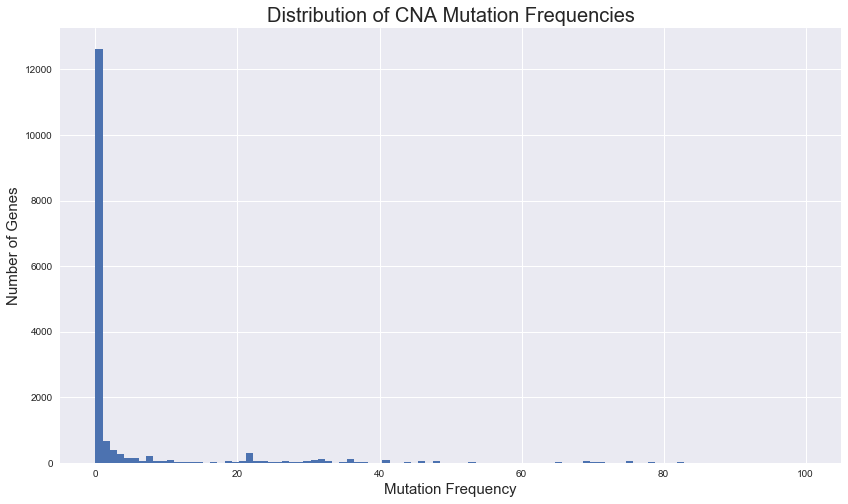

In [12]:
ax = final_cna_matrix.sum(axis=1).plot('hist', bins=np.linspace(0, 100, 100), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of CNA Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)

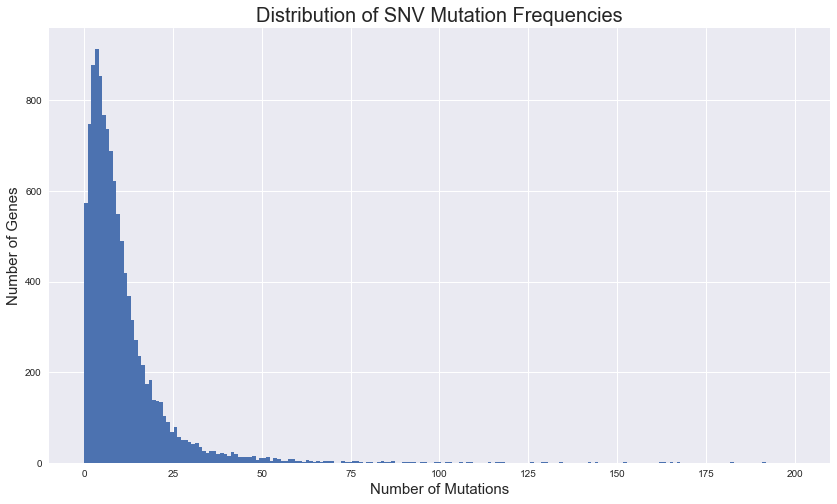

In [13]:
ax = final_matrix_sn.sum(axis=1).plot('hist', bins=np.linspace(0, 200, 200), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of SNV Mutation Frequencies', fontsize=20)
ax.set_xlabel('Number of Mutations', fontsize=15)

## Add SNVs and CNAs
Finally, let's add the CNAs and SNVs for the genes together by using the sum of CNAs and SNVs for each gene and sample.

This corresponds somwhow to step filtering 4.i of the hotnet2 preprocessing.

In [14]:
#cna_snv_sample_mat = final_matrix_sn.append(final_cna_matrix)
#cna_snv_sample_mat.fillna(0, inplace=True)
#cna_snv_sample_mat = cna_snv_sample_mat.groupby(cna_snv_sample_mat.index).sum()
#cna_snv_sample_mat.shape, final_matrix_sn.index.isin(final_cna_matrix.index).sum()
final_cnas_with_muts = final_cna_matrix[final_cna_matrix.sum(axis=1) > 0]
final_matrix_sn.index.rename('Name', inplace=True)
cna_snv_sample_mat = pd.concat((final_matrix_sn, final_cnas_with_muts))

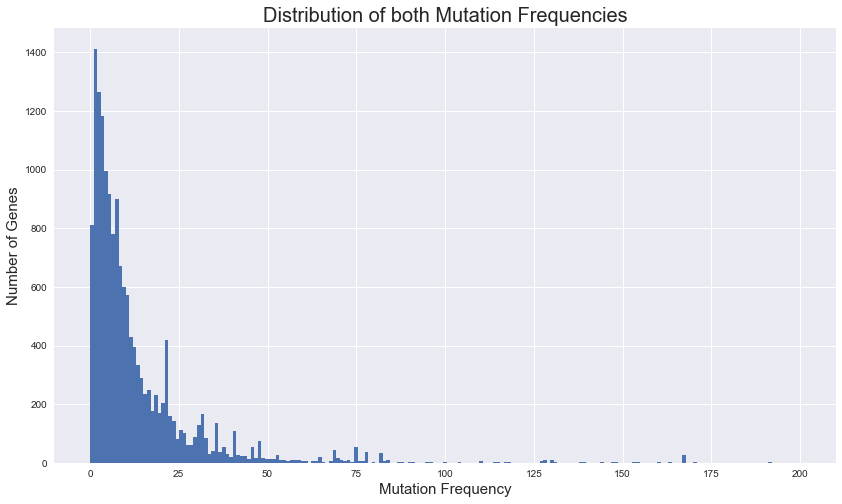

In [15]:
ax = cna_snv_sample_mat.sum(axis=1).plot('hist', bins=np.linspace(0, 200, 200), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of both Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)
print ("Number of genes in joint matrix: {}".format(cna_snv_sample_mat.shape[0]))

In [16]:
final_matrix = cna_snv_sample_mat

In [17]:
if USE_PRECOMPILED_MAF:
    final_matrix_sn.to_csv('../data/pancancer/TCGA/snv_samples_syn.tsv', sep='\t')
    final_cna_matrix.to_csv('../data/pancancer/TCGA/cna_samples_syn.tsv', sep='\t')
    cna_snv_sample_mat.to_csv('../data/pancancer/TCGA/mut_freqs_samples_syn.tsv', sep='\t')
else:
    final_matrix_sn.to_csv('../data/pancancer/TCGA/snv_samples_own.tsv', sep='\t')
    final_cna_matrix.to_csv('../data/pancancer/TCGA/cna_samples_own.tsv', sep='\t')
    cna_snv_sample_mat.to_csv('../data/pancancer/TCGA/mut_freqs_samples_own.tsv', sep='\t')

## Convert Gene Names to Ensembl IDs

In [18]:
# use mygene to get ensembl IDs from Hugo Symbols
mg = mygene.MyGeneInfo()
res = mg.querymany(final_matrix.index,
                   scopes='symbol',
                   fields='ensembl.gene, symbol',
                   species='human', returnall=True
                  )

# now, retrieve the names and IDs from a dictionary and put in DF
def get_name_and_id(x):
    ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
    name = x['symbol']
    query = x['query']
    if not name == query:
        print ("Error: ", name, query)
    return [ens_id, name]

ens_ids = [get_name_and_id(x) for x in res['out'] if 'ensembl' in x]
mapping = pd.DataFrame(ens_ids, columns=['Ensembl_ID', 'Name'])
mapping.set_index('Name', inplace=True)
mapping = mapping[~mapping.index.duplicated(keep='first')]

# join mutation frequencies with our derived mapping
mut_freq_sample = final_matrix.join(mapping)
print ("{} (of {}) genes had no mapping Ensembl ID".format(mut_freq_sample.Ensembl_ID.isnull().sum(),
                                                           mut_freq_sample.shape[0]))
mut_freq_sample.dropna(inplace=True) # remove unmapped genes simply

# make Ensembl ID the index and move Hugo Symbols to column
mut_freq_sample['Name'] = mut_freq_sample.index
mut_freq_sample.set_index('Ensembl_ID', inplace=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-15809...done.
Finished.
2505 input query terms found dup hits:
	[('AARS2', 2), ('AASDH', 2), ('ABAT', 2), ('ABCA11P', 2), ('ABCA2', 2), ('ABCB10', 2), ('ABCB8', 2),
680 input query terms found no hit:
	['ABP1', 'ACN9', 'ACPL2', 'ACRC', 'ADC', 'ADCK3', 'ADCK4', 'ADRBK1', 'ADRBK2', 'AGAP8', 'AGPAT6', 'A
697 (of 15809) genes had no mapping Ensembl ID


In [19]:
mut_freq_sample.drop('Name', axis=1).sum().sum()

127077.0

## Mean Across Cancer Types

In [20]:
samples_to_cancer_types = pd.read_csv('../data/pancancer/TCGA/pancan12_tumor_ids.tsv', sep='\t', header=None,
                                     names=['sample', 'cancer_type'])
samples_to_cancer_types['sample'] = samples_to_cancer_types['sample'].map(trim_fun)
samples_to_cancer_types.set_index('sample', inplace=True)

In [21]:
no_names = mut_freq_sample.drop('Name', axis=1)
matrix_with_cancer_types = no_names.T.join(samples_to_cancer_types)
print (matrix_with_cancer_types.drop('cancer_type', axis=1).sum().sum())
mean_mut_freqs = matrix_with_cancer_types.groupby('cancer_type').mean().T
print (mean_mut_freqs.sum().sum())
if USE_PRECOMPILED_MAF:
    mean_mut_freqs.to_csv('../data/pancancer/TCGA/mean_mut_freqs_cancer_types_syn.tsv', sep='\t')
else:
    mean_mut_freqs.to_csv('../data/pancancer/TCGA/mean_mut_freqs_cancer_types_own.tsv', sep='\t')

127077.0
597.5677529963008


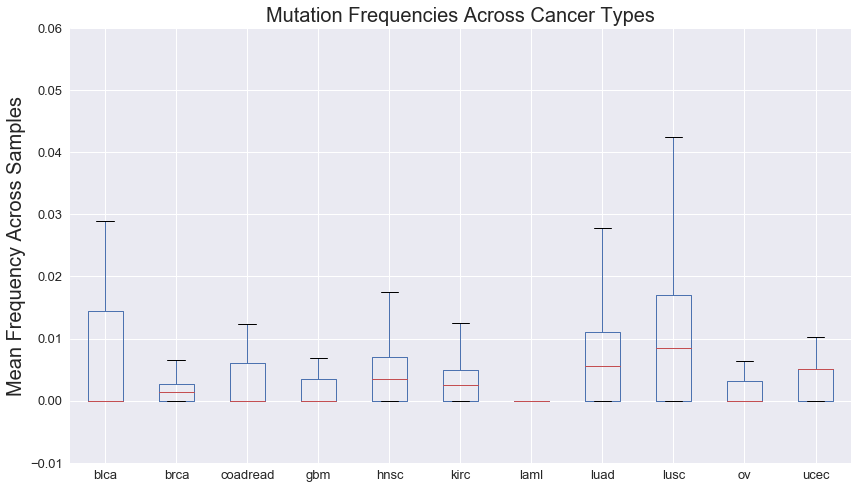

In [22]:
ax = mean_mut_freqs.plot.box(figsize=(14, 8), ylim=[-.01, .06], fontsize=13)
ax.set_ylabel('Mean Frequency Across Samples', fontsize=20)
ax.set_title('Mutation Frequencies Across Cancer Types', fontsize=20)

In [23]:
mean_mut_freqs.head()

cancer_type,blca,brca,coadread,gbm,hnsc,kirc,laml,luad,lusc,ov,ucec
ENSG00000121410,0.014493,0.002635,0.000000,0.003448,0.010490,0.0025,0.0,0.000000,0.008475,0.000000,0.000000
ENSG00000175899,0.043478,0.009223,0.012270,0.010345,0.003497,0.0075,0.0,0.044444,0.059322,0.003215,0.010204
ENSG00000128274,0.000000,0.001318,0.006135,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.000000,0.000000
ENSG00000094914,0.000000,0.002635,0.000000,0.000000,0.017483,0.0000,0.0,0.000000,0.008475,0.003215,0.005102
ENSG00000081760,0.000000,0.002635,0.000000,0.006897,0.003497,0.0000,0.0,0.005556,0.008475,0.006431,0.005102


## Put Feature Matrices into HDF5 Container

In [24]:
# load Container
data_file = '../data/pancancer/hotnet_iref_vec_input_unbalanced.h5'

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [35]:
mut_freq_sample[mut_freq_sample.Name.isin(nodes_df.name)].shape, mut_freq_sample[mut_freq_sample.index.isin(nodes_df.index)].shape

((8303, 2960), (8311, 2960))

In [32]:
# first, bring node names to DF
nodes_df = pd.DataFrame(node_names, columns=['ensembl_id', 'name'])
nodes_df.set_index('ensembl_id', inplace=True)

# clean mutation frequencies from genes which are not in network
mutfreq_in_network = mut_freq_sample[mut_freq_sample.index.isin(nodes_df.index)]
mean_mutfreq_in_network = mean_mut_freqs[mean_mut_freqs.index.isin(nodes_df.index)]
print (mutfreq_in_network.shape, mean_mutfreq_in_network.shape)

# remove duplicates in index
mutfreq_in_network = mutfreq_in_network[~mutfreq_in_network.index.duplicated(keep='first')]
mean_mutfreq_in_network = mean_mutfreq_in_network[~mean_mutfreq_in_network.index.duplicated(keep='first')]
print (mutfreq_in_network.shape, mean_mutfreq_in_network.shape)

# build feature matrix using reindexing
features_df = mutfreq_in_network.reindex(index=nodes_df.index)
features_df_mean = mean_mutfreq_in_network.reindex(index=nodes_df.index)

num_of_zero_nodes = features_df.isnull().any(axis=1).sum()
print ("{} out of {} nodes don't have any features assigned".format(num_of_zero_nodes, network.shape[0]))
print ("--> left with valid scores for {} genes".format(network.shape[0]-num_of_zero_nodes))

# put 0 for missing data and remove name columns
features_df.fillna(0, inplace=True)
features_df.drop('Name', axis=1, inplace=True)
features_df_mean.fillna(0, inplace=True)

(8311, 2960) (8311, 11)
(8303, 2960) (8303, 11)
3823 out of 12129 nodes don't have any features assigned
--> left with valid scores for 8306 genes


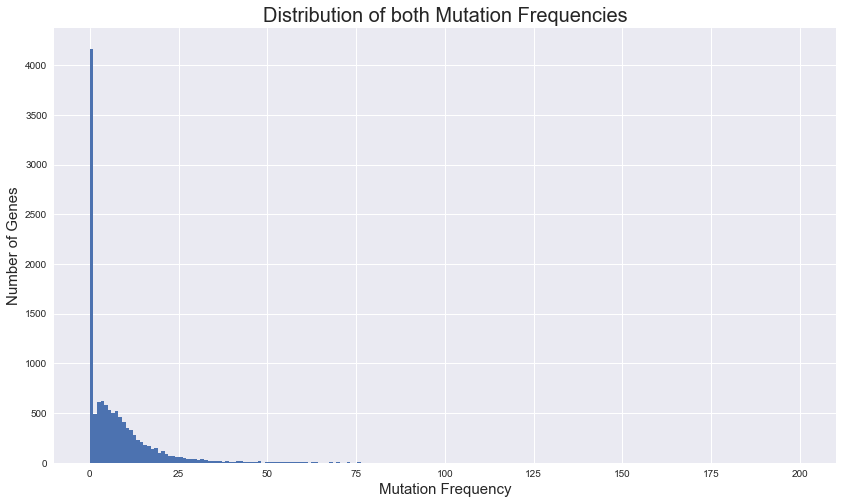

In [26]:
ax = features_df.sum(axis=1).plot('hist', bins=np.linspace(0, 200, 200), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of both Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)

In [36]:
features = features_df.as_matrix()
features_mean = features_df_mean.as_matrix()

string_dt = h5py.special_dtype(vlen=str)

# determine file name by parameters
if USE_PRECOMPILED_MAF:
    fname = '../data/pancancer/mutfreq_iref_unbalanced_syn.h5'
else:
    fname = '../data/pancancer/mutfreq_iref_unbalanced_own.h5'
f = h5py.File(fname, 'w')

# add ppi network
f.create_dataset('network', data=network, shape=network.shape)

# add features
f.create_dataset('features', data=features, shape=features.shape)
f.create_dataset('features_mean', data=features_mean, shape=features_mean.shape)

# add gene names (same order as features & network)
f.create_dataset('gene_names', data=node_names, dtype=string_dt)
# add labels
f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
if y_val is not None:
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)

f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
if y_val is not None:
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.close()
print ("Container written to {}".format(fname))

Container written to ../data/cancer/mutfreq_iref_unbalanced_syn.h5


NameError: name 'features_mean' is not defined